In [ ]:
import numpy as np
import tensorflow as tf
import cv2
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/Colab Notebooks/leapGestRecog.zip" -d leapgestrecog

Streaming output truncated to the last 5000 lines.
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0027.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0028.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0029.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0030.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0031.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0032.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0033.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0034.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0035.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0036.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0037.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0038.png  
  inflating: leapgestrecog/leapGestRe

In [ ]:
def load_images_and_labels(base_path):
    images = []
    labels = []
    gesture_mapping = {
        "01_palm": 0,
        "02_l": 1,
        "03_fist": 2,
        "04_fist_moved": 3,
        "05_thumb": 4,
        "06_index": 5,
        "07_ok": 6,
        "08_palm_moved": 7,
        "09_c": 8,
        "10_down": 9
    }

    for subject_folder in os.listdir(base_path):
        subject_path = os.path.join(base_path, subject_folder)
        if os.path.isdir(subject_path):
            print(f"Processing subject folder: {subject_folder}")
            for gesture_folder in os.listdir(subject_path):
                gesture_path = os.path.join(subject_path, gesture_folder)
                if os.path.isdir(gesture_path):
                    print(f"  Processing gesture folder: {gesture_folder}")
                    for img_name in os.listdir(gesture_path):
                        img_path = os.path.join(gesture_path, img_name)
                        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                        if img is not None:
                            img = cv2.resize(img, (64, 64))
                            images.append(img)
                            labels.append(gesture_mapping[gesture_folder])
                        else:
                            print(f"    Failed to read image: {img_path}")

    images = np.array(images, dtype='float32') / 255.0
    images = np.expand_dims(images, axis=-1)
    labels = to_categorical(labels, num_classes=10)
    return images, labels

base_path = 'leapgestrecog/leapGestRecog'
images, labels = load_images_and_labels(base_path)

Processing subject folder: 06
  Processing gesture folder: 10_down
  Processing gesture folder: 09_c
  Processing gesture folder: 07_ok
  Processing gesture folder: 04_fist_moved
  Processing gesture folder: 02_l
  Processing gesture folder: 01_palm
  Processing gesture folder: 06_index
  Processing gesture folder: 08_palm_moved
  Processing gesture folder: 05_thumb
  Processing gesture folder: 03_fist
Processing subject folder: 07
  Processing gesture folder: 10_down
  Processing gesture folder: 09_c
  Processing gesture folder: 07_ok
  Processing gesture folder: 04_fist_moved
  Processing gesture folder: 02_l
  Processing gesture folder: 01_palm
  Processing gesture folder: 06_index
  Processing gesture folder: 08_palm_moved
  Processing gesture folder: 05_thumb
  Processing gesture folder: 03_fist
Processing subject folder: 05
  Processing gesture folder: 10_down
  Processing gesture folder: 09_c
  Processing gesture folder: 07_ok
  Processing gesture folder: 04_fist_moved
  Process

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f'Training set size: {X_train.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')

Training set size: 16000
Test set size: 4000


In [ ]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

base_path = 'leapgestrecog/leapGestRecog'
images, labels = load_images_and_labels(base_path)

print(f"Number of images loaded: {len(images)}")
print(f"Number of labels loaded: {len(labels)}")
if len(images) == 0:
    print("No images loaded. Please check the dataset path and structure.")
else:
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=32),
        epochs=50,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, model_checkpoint]
    )

    model.load_weights('best_model.h5')

    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

    def predict_gesture(image_path):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            image = cv2.resize(image, (64, 64))
            image = image.reshape(1, 64, 64, 1)
            image = image / 255.0
            prediction = model.predict(image)
            predicted_label = np.argmax(prediction)
            return list(gesture_mapping.keys())[list(gesture_mapping.values()).index(predicted_label)]
        else:
            return "Image not found or corrupted"

    custom_image_path = 'path_to_your_custom_image.jpg'
    predicted_gesture = predict_gesture(custom_image_path)
    print(f'Predicted Gesture: {predicted_gesture}')

    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

Processing subject folder: 06
  Processing gesture folder: 10_down
  Processing gesture folder: 09_c
  Processing gesture folder: 07_ok
  Processing gesture folder: 04_fist_moved
  Processing gesture folder: 02_l
  Processing gesture folder: 01_palm
  Processing gesture folder: 06_index
  Processing gesture folder: 08_palm_moved
  Processing gesture folder: 05_thumb
  Processing gesture folder: 03_fist
Processing subject folder: 07
  Processing gesture folder: 10_down
  Processing gesture folder: 09_c
  Processing gesture folder: 07_ok
  Processing gesture folder: 04_fist_moved
  Processing gesture folder: 02_l
  Processing gesture folder: 01_palm
  Processing gesture folder: 06_index
  Processing gesture folder: 08_palm_moved
  Processing gesture folder: 05_thumb
  Processing gesture folder: 03_fist
Processing subject folder: 05
  Processing gesture folder: 10_down
  Processing gesture folder: 09_c
  Processing gesture folder: 07_ok
  Processing gesture folder: 04_fist_moved
  Process

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
500/500 [==============================] - 115s 231ms/step - loss: 1.1329 - accuracy: 0.5907 - val_loss: 0.5180 - val_accuracy: 0.8788
Epoch 3/50
500/500 [==============================] - 112s 223ms/step - loss: 0.8952 - accuracy: 0.6848 - val_loss: 0.3475 - val_accuracy: 0.8867
Epoch 4/50
500/500 [==============================] - 114s 229ms/step - loss: 0.7459 - accuracy: 0.7346 - val_loss: 0.2594 - val_accuracy: 0.9327
Epoch 5/50
500/500 [==============================] - 118s 236ms/step - loss: 0.6472 - accuracy: 0.7723 - val_loss: 0.1942 - val_accuracy: 0.9570
Epoch 6/50
500/500 [==============================] - 115s 230ms/step - loss: 0.5891 - accuracy: 0.7942 - val_loss: 0.1922 - val_accuracy: 0.9398
Epoch 7/50
500/500 [==============================] - 122s 243ms/step - loss: 0.5246 - accuracy: 0.8259 - val_loss: 0.1319 - val_accuracy: 0.9787
Epoch 8/50
500/500 [==============================] - 118s 235ms/step - loss: 0.4869 - accuracy: 0.8316 - val_loss: 0.1191 -

KeyboardInterrupt: 

In [ ]:
from google.colab import files
import numpy as np
import cv2
from tensorflow.keras.models import load_model

model.load_weights('best_model.h5')
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

125/125 [==============================] - 7s 56ms/step - loss: 0.0240 - accuracy: 0.9945
Test Accuracy: 99.45%


Saving testimg_1.png to testimg_1 (3).png
Saving testimg_2.png to testimg_2 (3).png
Saving testimg_3.png to testimg_3 (3).png
Saving testimg_4.png to testimg_4 (3).png
Saving testimg_5.png to testimg_5 (3).png
Saving testimg_6.png to testimg_6 (3).png
Saving testimg_7.png to testimg_7 (3).png
Saving testimg_8.png to testimg_8 (3).png
Saving testimg_9.png to testimg_9 (3).png
1/1 [==============================] - 0s 23ms/step


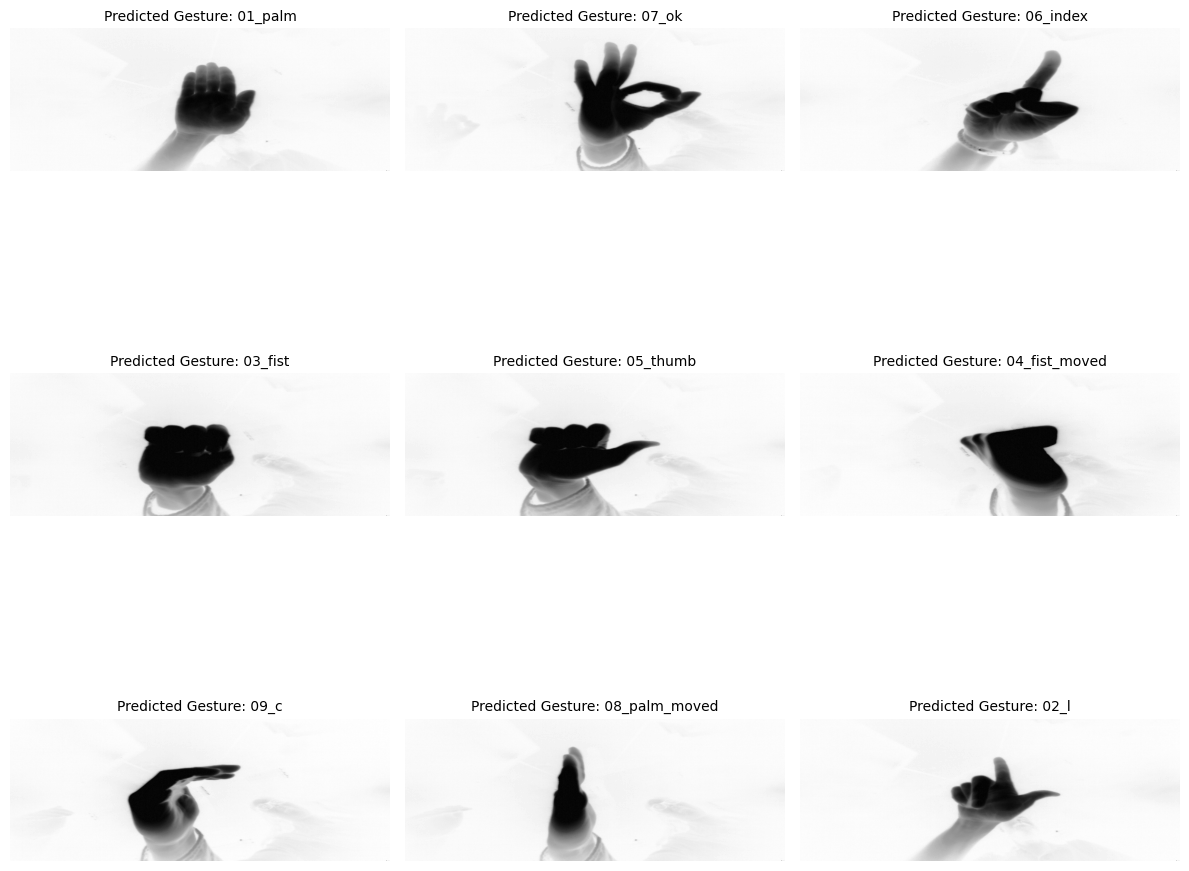

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

gesture_mapping = {
    0: "01_palm",
    1: "02_l",
    2: "03_fist",
    3: "04_fist_moved",
    4: "05_thumb",
    5: "06_index",
    6: "07_ok",
    7: "08_palm_moved",
    8: "09_c",
    9: "10_down"
}

model.load_weights('best_model.h5')

def flip_image(image):
    return cv2.flip(image, 1)

def convert_to_infrared(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    infrared_image = cv2.bitwise_not(image)
    return infrared_image

def predict_gesture(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        image = cv2.resize(image, (64, 64))
        image = image.reshape(1, 64, 64, 1)
        image = image / 255.0
        prediction = model.predict(image)
        predicted_label = np.argmax(prediction)
        return gesture_mapping[predicted_label]
    else:
        return "Image not found or corrupted"

uploaded = files.upload()
images = []
titles = []

for fn in uploaded.keys():
    custom_image_path = fn

    infrared_image = convert_to_infrared(custom_image_path)
    predicted_gesture = predict_gesture(custom_image_path)

    if infrared_image is not None:
        images.append(infrared_image)
        titles.append(f'Predicted Gesture: {predicted_gesture}')
    else:
        print(f"Error converting image {custom_image_path} to infrared.")

num_images = len(images)
cols = 3
rows = (num_images + cols - 1) // cols

if num_images < 9:
    rows = 3
    cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
axes = axes.flatten()

for i in range(9):
    if i < num_images:
        axes[i].imshow(images[i], cmap='gray')
        axes[i].set_title(titles[i], fontsize=10)
    else:
        axes[i].axis('off')
    axes[i].axis('off')

plt.tight_layout()
plt.show()